In [2]:
# dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib import colors

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

# Reflect Tables into SQLAlchemy ORM

In [6]:
# connecting notebook to sqlite file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# reflect an existing database into a new model
hawaii_weather = automap_base()

# reflect the tables
hawaii_weather.prepare(engine, reflect = True)

# printing class keys from database
print (hawaii_weather.classes.keys())

# # Save references to each table
measurement = hawaii_weather.classes.measurement
station = hawaii_weather.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

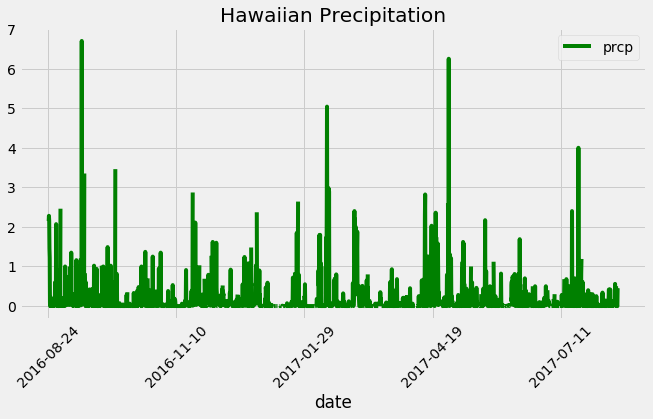

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(func.max(measurement.date)).first()[0]
last_date = dt.datetime.strptime(last_date,'%Y-%m-%d')

# Calculate the date 1 year ago from the last data point in the database
prev_year = last_date - dt.timedelta(365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date,measurement.prcp).filter(measurement.date>=prev_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
hawaii_df = pd.DataFrame(results).set_index("date")

# Sort the dataframe by date
hawaii_df = hawaii_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
hawaii_df.plot(rot = 45, figsize = (10,5), color = "green")
plt.title("Hawaiian Precipitation")
plt.savefig("Precipitation.png") 
plt.show()


In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
hawaii_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
hi_stations = session.query(station).count()
hi_stations

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_station = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
most_active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
select = [func.min(measurement.tobs),
         func.max(measurement.tobs),
         func.avg(measurement.tobs)]

select_query = session.query(*select).filter(measurement.station == "USC00519281").all()
select_query

[(54.0, 85.0, 71.66378066378067)]

<function matplotlib.pyplot.show(*args, **kw)>

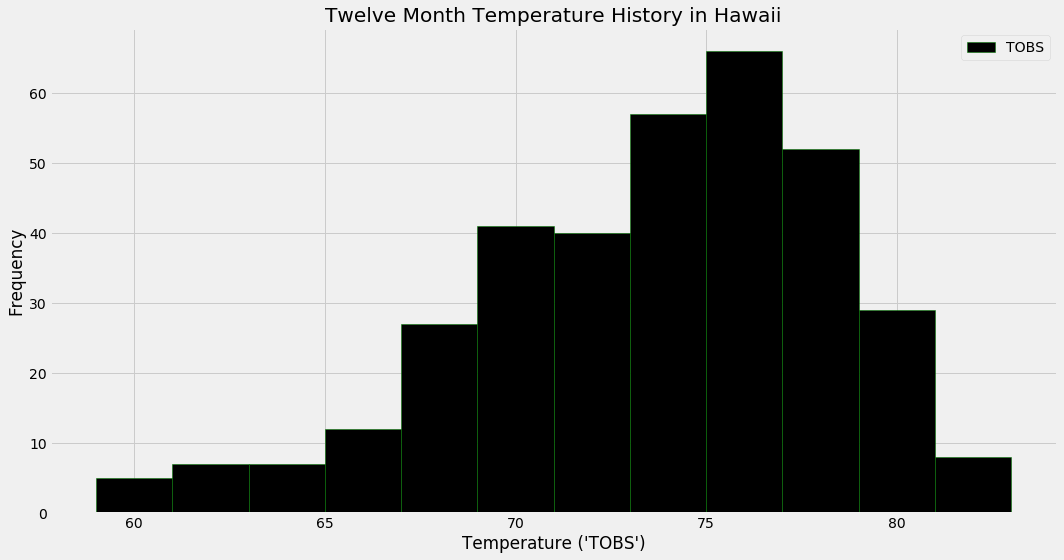

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(measurement.tobs).filter(measurement.date >=prev_year).\
            filter(measurement.station == "USC00519281").\
            order_by(measurement.date).all()

# Saving previous query into a dataframe
temp_df = pd.DataFrame(temp_data, columns=["TOBS"])

# Plotting histogram with 12 bins for a 12 month temp history of Hawaii
temp_df.plot.hist(bins = 12, color = "Black", ec="Green", title = "Twelve Month Temperature History in Hawaii")
plt.gcf().set_size_inches(15, 8)
plt.xlabel("Temperature ('TOBS')")
plt.legend(loc = "upper right")
plt.tight_layout()
plt.show






## Bonus Challenge Assignment

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
end_dt = dt.date(2012, 2, 28)
last_year = end_dt - dt.timedelta(days = 365)

print(calc_temps(last_year, end_dt))

[(56.0, 72.76152158010241, 86.0)]


<function matplotlib.pyplot.show(*args, **kw)>

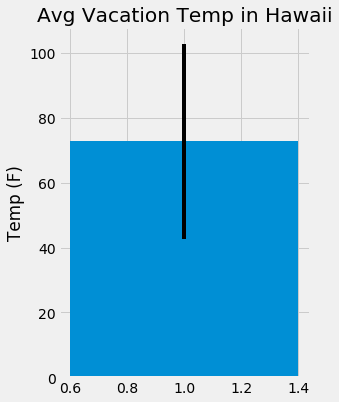

In [19]:
# Variables of min, max, and avg temp from 2011-2-28 to 2012-2-28
temp_min = 56.0
temp_max = 86.0
temp_avg = 72.76152158010241

# difference of min and max temps for the year
temp_diff = temp_max - temp_min

# plotting the average temperature with the variance of the temperatures for the year. 
plt. figure (figsize = (4, 6))
plt. tick_params (bottom = "off", top = "off", labelbottom = "off")
plt.bar(1, temp_avg, yerr=temp_diff)
plt.ylabel ("Temp (F)")
plt.title ("Avg Vacation Temp in Hawaii")
plt.show

In [33]:
hi_end_date = dt.date(2012, 2, 28)
start_date = hi_end_date - dt.timedelta(days=365)

# query station precipitation for the dates of vacation
all_stations = session.query(measurement.station, measurement.prcp, station.name, station.latitude,station.longitude, station.elevation).\
                filter(measurement.date >=start_date).filter(measurement.date <=hi_end_date).\
                group_by(measurement.station).\
                order_by(measurement.prcp.desc()).all()

# show query
all_stations

[('USC00519523', 0.02, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00519397', 0.0, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00519281', 0.0, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00516128', 0.0, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00513117', 0.0, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00511918', 0.0, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00518838', None, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00517948', None, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00514830', None, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)]

In [21]:
# Create a query that will calculate the daily normals
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)
def daily_normals(date):
    
    """Daily Normals.
    Args:
        date (str): A date string in the format ‘%m-%d’
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax"""
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# listing the dates for vacation
hawaii_trip = ["02-28", "02-29", "03-01", "03-02", "03-03","03-04","03-05"]
normals = []

# returning avg, min, max rainfall for Hawaii vacation
for day in hawaii_trip:
    date = {}
    date["Date"] = "{}".format(day)
    daily_norm = daily_normals(day)
    date["Min"] = daily_norm[0][0]
    date["Avg"] = round(daily_norm[0][1],1)
    date["Max"] = daily_norm[0][2]
    normals.append(date)
    
# creating dataframe for previous for loop
hawaii_trip_rainfall_df = pd.DataFrame(normals)
hawaii_trip_rainfall_df

,Date,Min,Avg,Max
0,02-28,65.0,70.7,80.0
1,02-29,67.0,71.7,79.0
2,03-01,64.0,70.0,76.0
3,03-02,61.0,70.4,78.0
4,03-03,60.0,70.1,78.0
5,03-04,57.0,69.3,77.0
6,03-05,60.0,67.9,76.0


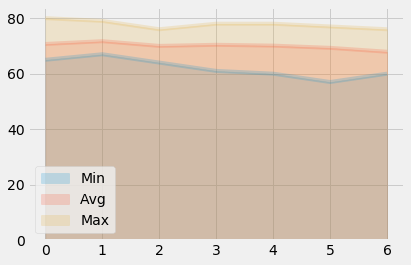

In [36]:
# plotting the min, avg, and max 
hawaii_trip_rainfall_df.plot(kind="area",alpha = 0.2, stacked = False)